In [ ]:
!pip install -q kaggle

!mkdir -p ~/.kaggle
                                  
!cp kaggle.json ~/.kaggle/    

!chmod 600 ~/.kaggle/kaggle.json


# Facial emotion recognition with vgg16 :
 


In [ ]:
!kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset

 89% 107M/121M [00:01<00:00, 73.6MB/s] 
100% 121M/121M [00:01<00:00, 86.9MB/s]


In [ ]:
from zipfile import ZipFile
zf = ZipFile('face-expression-recognition-dataset.zip', 'r')
zf.extractall('/content')
zf.close()

In [ ]:
!pip install tensorflow-gpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 588.3 MB 18 kB/s 
     |████████████████████████████████| 439 kB 25.6 MB/s 
     |████████████████████████████████| 1.7 MB 76.1 MB/s 
     |████████████████████████████████| 6.0 MB 77.3 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully u

In [ ]:
!nvidia-smi

Thu Dec 22 03:27:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    27W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Libraries:

In [ ]:
import tensorflow as tf
tf.__version__

'2.11.0'

In [ ]:
from tensorflow.keras.layers import Lambda,Input,Dense,Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19


In [ ]:
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
IMAGE_SIZE=[224,224]
train_path='images/train'

valid_path='images/validation'

In [ ]:
base_model = VGG19(input_shape=IMAGE_SIZE+[3],include_top=False)

80134624/80134624 [==============================] - 0s 0us/step


In [ ]:
for layer in base_model.layers:
  layer.trainable=False

In [ ]:
folders=glob('images/train/*')

In [ ]:
folders

['images/train/angry',
 'images/train/fear',
 'images/train/neutral',
 'images/train/surprise',
 'images/train/sad',
 'images/train/disgust',
 'images/train/happy']

In [ ]:
x=Flatten()(base_model.output)

We just want to change the last layer as we want to classify the emotions with desirable classes.

In [ ]:
prediction=Dense(len(folders),activation='softmax')(x)

model=Model(inputs=base_model.input,outputs=prediction)

Now checking the model.

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./model.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [early_stopping,checkpoint,reduce_learningrate]

In [ ]:
train_datagen=ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True)

test_datagen=ImageDataGenerator(rescale=1./255)

In [ ]:
training_set=train_datagen.flow_from_directory(train_path,
                                               target_size=(224,224),batch_size=32,class_mode='categorical')

Found 28821 images belonging to 7 classes.


In [ ]:
test_set=test_datagen.flow_from_directory(valid_path,
                                               target_size=(224,224),batch_size=32,class_mode='categorical')

Found 7066 images belonging to 7 classes.


In [22]:
history=model.fit_generator(training_set,validation_data=test_set,
                      epochs=30,
                      steps_per_epoch=len(training_set),
                      validation_steps=len(test_set))



<ipython-input-22-ae77dfb51629>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(training_set,validation_data=test_set,


Epoch 1/30
901/901 [==============================] - 378s 399ms/step - loss: 1.6804 - accuracy: 0.3942 - val_loss: 1.5386 - val_accuracy: 0.4588
Epoch 2/30
901/901 [==============================] - 344s 382ms/step - loss: 1.5570 - accuracy: 0.4558 - val_loss: 1.3584 - val_accuracy: 0.5095
Epoch 3/30
901/901 [==============================] - 351s 389ms/step - loss: 1.5090 - accuracy: 0.4771 - val_loss: 1.3435 - val_accuracy: 0.5167
Epoch 4/30
901/901 [==============================] - 344s 382ms/step - loss: 1.4209 - accuracy: 0.4965 - val_loss: 1.3986 - val_accuracy: 0.4989
Epoch 5/30
901/901 [==============================] - 344s 382ms/step - loss: 1.4037 - accuracy: 0.5003 - val_loss: 1.4473 - val_accuracy: 0.4878
Epoch 6/30
901/901 [==============================] - 342s 379ms/step - loss: 1.4171 - accuracy: 0.5057 - val_loss: 1.5857 - val_accuracy: 0.4917
Epoch 7/30
901/901 [==============================] - 342s 379ms/step - loss: 1.3732 - accuracy: 0.5169 - val_loss: 1.4900 -

In [23]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

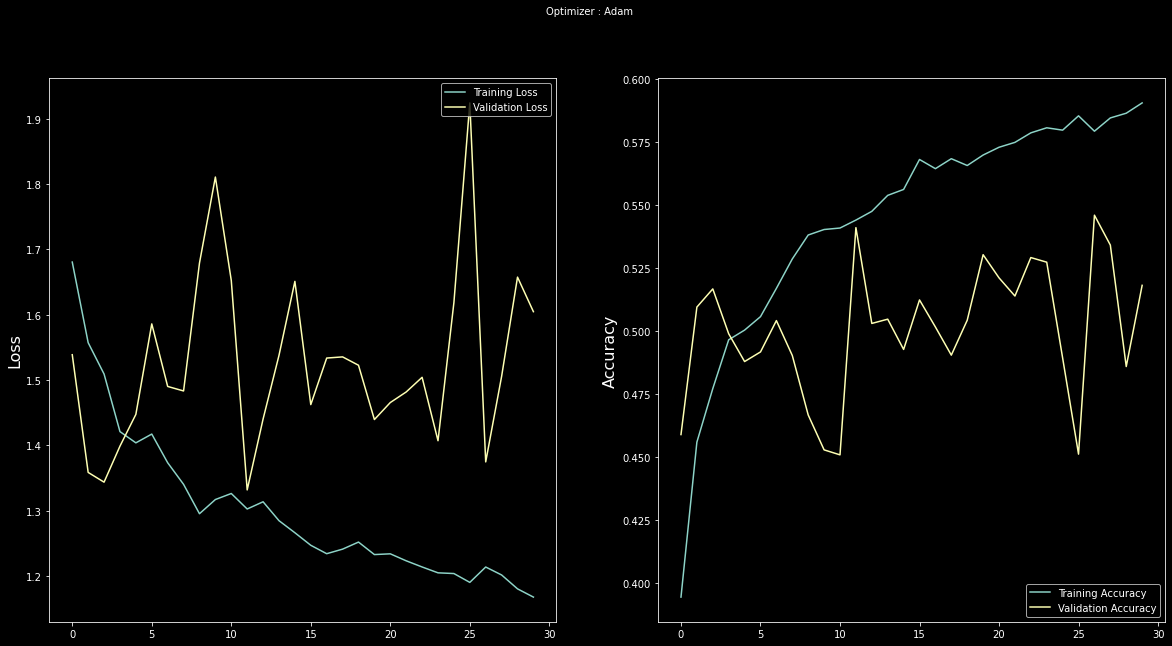

In [24]:
plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()


<ipython-input-26-e520dd0618a9>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(generator=test_set)


<Figure size 432x288 with 0 Axes>

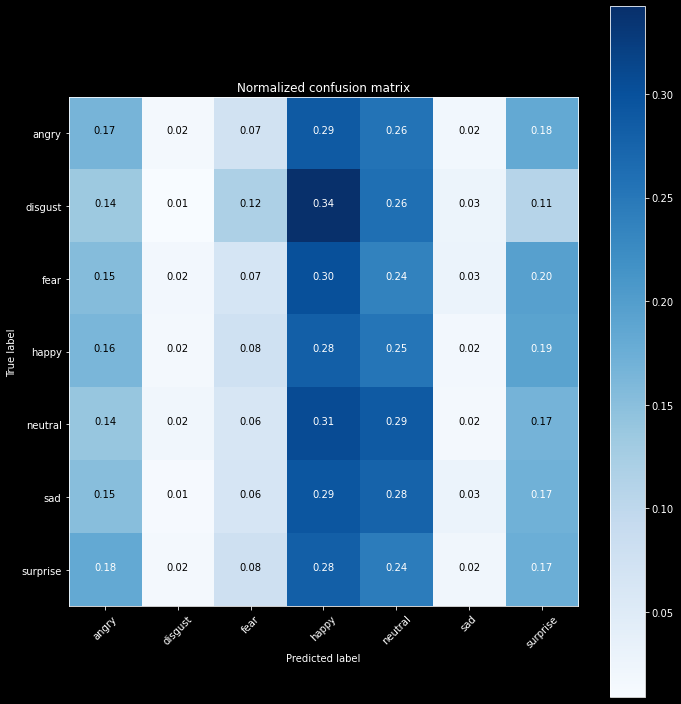

In [26]:
# compute predictions
predictions = model.predict_generator(generator=test_set)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = test_set.classes
class_names = test_set.class_indices.keys()

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()